In [1]:
import numpy as np
import json
import yaml
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib.ticker import MaxNLocator

import xobjects as xo
import xtrack as xt
import xpart as xp
import xcoll as xc


import pymadx
#from xcoll_plotting import plot_functions as xcp

print('\nxcoll version: ', xc.__version__)
print('xtrack version: ', xt.__version__)
print('xpart version: ', xp.__version__)
print('xobjects version: ', xo.__version__)

context = xo.ContextCpu() 
seed = 1927034333


xcoll version:  0.5.12
xtrack version:  0.83.0
xpart version:  0.23.0
xobjects version:  0.5.0


In [2]:
import re
import io
import json
import gzip
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from functools import lru_cache

import pandas as pd
from ruamel.yaml import YAML

import xtrack as xt
import xcoll as xc


# Some default constants
DEFAULT_FIGSIZE = (6.5, 4)

# Utility functions
def convert_m_to_mm(val):
    return val / 1e-3


def remove_xticks(ax):
    ax.tick_params(
            axis='both',  # changes apply to the x-axis
            which='both',  # both major and minor ticks are affected
            bottom=False,  # ticks along the bottom edge are off
            top=False,  # ticks along the top edge are off
            left=True,  # ticks along the top edge are off
            right=False,  # ticks along the top edge are off
            labelbottom=False,
            labeltop=False,
            labelleft=True,
            labelright=False,
    )


def remove_all_ticks(ax):
    ax.tick_params(
            axis='both',  # changes apply to the x-axis
            which='both',  # both major and minor ticks are affected
            bottom=False,  # ticks along the bottom edge are off
            top=False,  # ticks along the top edge are off
            left=False,  # ticks along the top edge are off
            right=False,  # ticks along the top edge are off
            labelbottom=False,
            labeltop=False,
            labelleft=False,
            labelright=False,
    )

    lw = 0.5
    ax.spines["bottom"].set_linewidth(lw)
    ax.spines["top"].set_linewidth(lw)
    ax.spines["left"].set_linewidth(lw)
    ax.spines["right"].set_linewidth(lw)


def remove_spines(ax):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)


# Data loader functions
def load_yaml_dict_from_file(file):
    with open(file, 'r') as fid:
        yaml = YAML()
        full_dct = yaml.load(fid)
    return full_dct


def colldb_format_detector(colldb_file, **kwargs):
    # Detect the likely format of a colldb file
    lines = []
    formats = ('collgaps', 'old_colldb', 'new_colldb', 'yaml_colldb')
    formats_found = {fmt: False for fmt in formats}

    all_old_colldb_lines = True
    all_collgaps_lines = True
    has_yaml_syntax = False
    with open(colldb_file, 'r') as infile:
        for l_no, line in enumerate(infile):
            line = line.strip()
            if line.startswith("#"):
                continue  # Comment
            if len(line.strip()) == 0:
                continue  # Empty line
            lines.append(line)
            # Detect based on the number of items on a line or
            # special charecters for the case of yaml
            if line == '---' or ':' in line:
                has_yaml_syntax = True
            elif len(line.split()) == 1: # Line from an old CollDB
                all_collgaps_lines = False
            elif len(line.split()) == 13:  # Line from collgaps
                all_old_colldb_lines = False
            else:
                all_collgaps_lines = False
                all_old_colldb_lines = False

    formats_found['yaml_colldb'] = has_yaml_syntax
    formats_found['old_colldb'] = all_old_colldb_lines
    formats_found['collgaps'] = all_collgaps_lines
    # The default case is the new CollDB
    # The loader there has checking for valid formats
    formats_found['new_colldb'] = not all_old_colldb_lines \
                                    and not all_collgaps_lines \
                                    and not has_yaml_syntax
    assert sum(formats_found.values()) == 1

    likely_format = [key for key in formats_found if formats_found[key] == True][0]
    print(f"Detected CollDB format: {likely_format}")
    return likely_format


def load_colldb_yaml(filename, beam=None):
    colldb = xc.CollimatorDatabase.from_yaml(file=filename, beam=beam)

    return colldb


def convert_to_xcoll_collimator_dict(collimator_df):
    xcoll_coll_dict = {'families':{}, 'Collimators': {}}

    for kk, vv in collimator_df.T.to_dict().items():
        xcoll_coll_dict['Collimators'][kk] = {}
        xcoll_coll_dict['Collimators'][kk]['gap'] = vv['nsigma']
        xcoll_coll_dict['Collimators'][kk]['angle'] = vv['angle']
        xcoll_coll_dict['Collimators'][kk]['length'] = vv['length']
        xcoll_coll_dict['Collimators'][kk]['material'] = vv['material']

    return xcoll_coll_dict


def load_collimators_data(line, optics_df, collimator_file, nemitt_x, nemitt_y, beam):    

    detected_format = colldb_format_detector(collimator_file)

    line.discard_tracker()
    xcoll_config = dict(line=line, nemitt_x=nemitt_x, nemitt_y=nemitt_y, beam=beam)

    if detected_format in ('collgaps', 'old_colldb','new_colldb'):
        coll_dict = load_collimator_file(collimator_file)
        coll_dict_xcoll = convert_to_xcoll_collimator_dict(coll_dict)

        coll_manager = xc.CollimatorManager.from_dict(file=coll_dict_xcoll, 
                                                      **xcoll_config)
    
    else:
        coll_manager = xc.CollimatorManager.from_yaml(file=collimator_file, 
                                                      **xcoll_config)

    coll_manager.install_black_absorbers(verbose=False)
    coll_manager.build_tracker()
    coll_manager.set_openings()

    coll_df = coll_manager.colldb._colldb

    collimator_optics = optics_df.loc[coll_df.index]   
    coll_data = pd.merge(coll_df, collimator_optics, 
                         left_index=True, right_index=True, how='inner')

    return coll_data


def load_collimator_file(collimator_file, **kwargs):
        detected_format = colldb_format_detector(collimator_file, **kwargs)
        loader_dispatch = {'collgaps': load_collgaps, 
                           'new_colldb': load_colldb_new, 
                           'old_colldb': load_colldb_old,
                           'yaml_colldb': load_colldb_yaml}

        data = loader_dispatch[detected_format](collimator_file, **kwargs)
        return data


def load_collgaps(filename):
     names = ["id", "name", "angle", "betax",  "betay",  "halfgap", "material",
              "length", "sigx", "sigy", "tilt1",  "tilt2", "nsigma"]

     df = pd.read_csv(filename, delim_whitespace=True, index_col=False,
                      names=names, header=0, comment='#')
     df["name"] = df["name"].str.lower() # to match the Xsuite files
     df["angle"] = df["angle"].apply(np.deg2rad)
     df = df.set_index("name")

     return df


def load_colldb_new(filename):
    with open(filename, "r") as infile:
        coll_data_string = ""
        family_settings = {}
        family_types = {}
        onesided = {}
        tilted = {}

        for l_no, line in enumerate(infile):
            if line.startswith("#"):
                continue  # Comment
            if len(line.strip()) == 0:
                continue  # Empty line
            sline = line.split()
            if len(sline) < 6:
                if sline[0].lower() == "nsig_fam":
                    family_settings[sline[1]] = sline[2]
                    family_types[sline[1]] = sline[3]
                elif sline[0].lower() == "onesided":
                    onesided[sline[1]] = int(sline[2])
                elif sline[0].lower() == "tilted":
                    tilted[sline[1]] = [float(sline[2]), float(sline[3])]
                elif sline[0].lower() == "settings":
                    pass  # Acknowledge and ignore this line
                else:
                    raise ValueError(f"Unknown setting {line}")
            else:
                coll_data_string += line

    names = ["name", "opening", "material", "length", "angle", "offset"]

    df = pd.read_csv(io.StringIO(coll_data_string), delim_whitespace=True,
                     index_col=False, skip_blank_lines=True, names=names)

    df["name"] = df["name"].str.lower() # Make the names lowercase for easy processing
    df["nsigma"] = df["opening"].apply(lambda s: float(family_settings.get(s, s)))
    df["type"] = df["opening"].apply(lambda s: family_types.get(s, "UNKNOWN"))
    df["side"] = df["name"].apply(lambda s: onesided.get(s, 0))
    # Tilt angles given in degrees, but used in radians [for now]
    df["tilt_left"] = df["name"].apply(lambda s: np.deg2rad(tilted.get(s, [0, 0])[0]))
    df["tilt_right"] = df["name"].apply(lambda s: np.deg2rad(tilted.get(s, [0, 0])[1]))
    df = df.set_index("name")

    # Ensure the collimators marked as one-sided or tilted are actually defined
    defined_set = set(df.index)
    onesided_set = set(onesided.keys())
    tilted_set = set(tilted.keys())
    if not onesided_set.issubset(defined_set):
        different = onesided_set - defined_set
        raise SystemExit('One-sided collimators not defined: {}'.format(", ".join(different)))
    if not tilted_set.issubset(defined_set):
        different = tilted_set - defined_set
        raise SystemExit('Tilted collimators not defined: {}'.format(",".join(different)))
    
    return df


def load_colldb_old(filename):
    float_num = '[-+]?(\d+(\.\d*)?|\.\d+)([eE][-+]?\d+)?'  # Float
    sep = '\s+'

    # Not sure what the value 3 from last is, so it is not named
    coll_re = re.compile(r'''
    #{sep}
    (?P<name>.+){sep}
    (?P<name_lower>.+){sep}
    (?P<nsigma>{float_num}){sep}
    (?P<material>[a-zA-Z]+){sep}
    (?P<length>{float_num}){sep}
    (?P<angle>{float_num}){sep}
    ({float_num}){sep}
    (?P<betax>{float_num}){sep}
    (?P<betay>{float_num}){sep}
    '''.format(sep=sep, float_num=float_num), re.VERBOSE)

    with open(filename, "r") as infile:
        colldb_contents = infile.read()

    # List of dicts for each match (collimator)
    matches = [m.groupdict() for m in coll_re.finditer(colldb_contents)]

    # Make into a dict by name for easy access
    collimator_data = {}
    for m in matches:
        if m['name'] in collimator_data:
            print(m['name'])
            
        collimator_data[m["name"]] = {"nsigma" : float(m["nsigma"]),
                                      "angle" : np.rad2deg(float(m["angle"])),
                                      "length" : float(m["length"]),
                                      "material": m["material"],
                                      }

    collimator_data_df = pd.DataFrame(collimator_data).T
    collimator_data_df.index = collimator_data_df.index.str.lower()
    return collimator_data_df


def load_and_process_xsuite_line(jsonfile, nemitt_x, nemitt_y):
    # load the line and compute optics
    with open(jsonfile, 'r') as fid:
        line = xt.Line.from_dict(json.load(fid))
    line.build_tracker()

    line.twiss_default['method'] = '4d'
    xt_twiss = line.twiss()

    optics_df = xt_twiss.to_pandas().set_index('name')
    sigmas = xt_twiss.get_betatron_sigmas(nemitt_x, nemitt_y)
    sigmas_df = pd.DataFrame({kk: sigmas[kk] for kk in sigmas.cols.names 
                             if np.array(sigmas[kk]).ndim==1}).set_index('name')

    aperture_limits = load_apertures(line)

    return optics_df, sigmas_df, aperture_limits, line


def load_all_data(xsuite_json_line, collimator_file, nemitt_x, nemitt_y, beam):

    (optics_df, sigmas_df,
        aperture_df, line) = load_and_process_xsuite_line(xsuite_json_line, nemitt_x, nemitt_y)
    
    coll_data = load_collimators_data(line, optics_df, collimator_file,
                                       nemitt_x, nemitt_y, beam=beam)
    
    return {'optics': optics_df, 'sigmas': sigmas_df, 
            'aperture': aperture_df, 'collimators': coll_data}


def find_axis_intercepts(x_coords, y_coords):
    x_intercepts = []
    y_intercepts = []

    for i in range(len(x_coords)):
        x1, y1 = x_coords[i], y_coords[i]
        x2, y2 = x_coords[(i + 1) % len(x_coords)], y_coords[(i + 1) % len(y_coords)]

        if x1 == x2:
        # Vertical line, no y-intercept
            y_intercept = 0.0 if x1 == x2 == 0.0 else None
        else:
            slope = (y2 - y1) / (x2 - x1)
            y_intercept = y1 - (slope * x1)

        if y1 == y2:
        # Horizontal line, no x-intercept
            x_intercept = 0.0 if y1 == y2 == 0.0 else None
        else:
            slope = (x2 - x1) / (y2 - y1)
            x_intercept = x1 - (slope * y1)

        # Check if the x-intercept is within the range of x1 and x2
        if x_intercept is not None and (x1 <= x_intercept <= x2 or x2 <= x_intercept <= x1):
            x_intercepts.append(x_intercept)

        # Check if the y-intercept is within the range of y1 and y2
        if y_intercept is not None and (y1 <= y_intercept <= y2 or y2 <= y_intercept <= y1):
            y_intercepts.append(y_intercept)

    return x_intercepts, y_intercepts


def find_apertures(line):
    i_apertures = []
    apertures = []
    for ii, ee in enumerate(line.elements):
        if ee.__class__.__name__.startswith('Limit'):
            i_apertures.append(ii)
            apertures.append(ee)
    return np.array(i_apertures), np.array(apertures)


def load_apertures(line):
    apertures = find_apertures(line)

    ap_spos = np.take(line.get_s_elements(), apertures[0])

    ap_limit_dict = {}
    for ii, ap in enumerate(apertures[1]):
        ap_dict = ap.to_dict()
        cname = ap.__class__.__name__
        if cname == 'LimitEllipse':
            x_min = -ap_dict['a']
            x_max = ap_dict['a']
            y_min = -ap_dict['b']
            y_max = ap_dict['b']
        elif cname == 'LimitRect':
            x_min = ap_dict['min_x']
            x_max = ap_dict['max_x']
            y_min = ap_dict['min_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitRectEllipse':
            x_min = -ap_dict['max_x']
            x_max = ap_dict['max_x']
            y_min = -ap_dict['max_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitRacetrack':
            x_min = ap_dict['min_x']
            x_max = ap_dict['max_x']
            y_min = ap_dict['min_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitPolygon':
            x_intercepts, y_intercepts = find_axis_intercepts(ap_dict['x_vertices'], 
                                                             ap_dict['y_vertices'])
            x_min = min(x_intercepts)
            x_max = max(x_intercepts)
            y_min = min(y_intercepts)
            y_max = max(y_intercepts)
        else:
            raise ValueError(f'Cannot proceed with aperture: {ap_dict}')
        s_pos = ap_spos[ii]
        ap_limit_dict[s_pos] = {'xmin': x_min, 'xmax': x_max, 
                                'ymin': y_min, 'ymax': y_max, 'apertype': cname}
    
    ap_limit_df = pd.DataFrame.from_dict(ap_limit_dict, orient='index')

    return ap_limit_df


def get_collimator_plane_mask(coll_data, plane):
    ang_tol = 0.05
    # Take the angle of the left jaw without loss of generality
    # No real cases when the angles for L and R are not the same
    if plane == 'h':
        mask = np.abs(np.sin(np.deg2rad(coll_data['angle_L'].astype(float)))) < ang_tol
    elif plane == 'v':
        mask = np.abs(np.cos(np.deg2rad(coll_data['angle_L'].astype(float)))) < ang_tol
    else:
        raise Exception('Allowed planes are h and v')
    return mask


# Axis plotting functions - plot data on a given plot axis
def _get_twiss_header(tfsfile):
    header = None
    line_no = 0

    gzipped = tfsfile.endswith(".gz")
    fopen = gzip.open if gzipped else open

    flag = "rb" if gzipped else "r"
    with fopen(tfsfile, flag) as filein:
        for idx, line in enumerate(filein):
            if gzipped:
                line = line.decode("utf-8")
            if line.startswith("*"):  # This is the header line, preamble lines start with @
                header = line.replace("*", "").strip().split()  # Strip the comment char
                line_no = idx + 1  # As zero counted
                break  # End the loop early - information found

    return header, line_no


@lru_cache(maxsize=5)
def _load_layout_tfs(tfsfile):
    header, header_line_no = _get_twiss_header(tfsfile)

    required_columns = {"KEYWORD", "S", "L", "K1L", "NAME"}

    if not required_columns.issubset(set(required_columns)):
        raise KeyError("The required columns in the MAD-X"
                       " TFS file are: {}".format(" ".join(list(required_columns))))

    twiss = pd.read_csv(tfsfile, delim_whitespace=True, skiprows=header_line_no+1,
                        index_col=False, names=header)

    twiss = twiss[list(required_columns)] # Reduce the data fields
    twiss["NAME"] = twiss["NAME"].str.upper() # Make the names uppercase
    twiss = twiss.set_index("NAME")

    return twiss


def draw_layout(tfs_df, axis):
    lim = (tfs_df["S"].min(), tfs_df["S"].max())
    centres = tfs_df["S"] - tfs_df["L"]/2

    y_span = 2
    def offseter(k1l):
        if k1l > 0:
            offset = 0
        elif k1l < 0:
            offset = -y_span
        else:
            offset = -y_span / 2
        return offset

    colours= {
        "QUADRUPOLE": u'#d10000',
        "RBEND": u'#0066cc',
        "SBEND": u'#0066cc',
        "RCOLLIMATOR": "black",
        "ECOLLIMATOR": "black",
        "COLLIMATOR": "black",
        "HKICKER": u'#4c33b2',
        "VKICKER": u'#ba55d3',
        "TKICKER": 'darkmagenta',
        "OCTUPOLE": u'#00994c',
        "SEXTUPOLE": u'#ffcc00',
        "SOLENOID": u'#ffa500',
        "MULTIPOLE": "gray"
    }

    offsets = tfs_df["K1L"].apply(offseter)
    colour = tfs_df["KEYWORD"].apply(lambda k: colours.get(k, "white"))
    heights = np.full_like(centres.values, y_span)

    bar = axis.bar(x=centres, height=heights,
                   bottom=offsets, width=tfs_df["L"], color=colour,
                   edgecolor=colour, linewidth=0.3)

    line = axis.axhline(0, color='gray', lw=0.5, zorder=0)
    axis.set_xlim(lim)


def plot_layout(layout_tfs, axis, tooltips=True, tooltip_markers=True):
    tfs_df = _load_layout_tfs(layout_tfs)
    tfs_df = tfs_df[(tfs_df["L"] > 0) & (tfs_df["KEYWORD"] != "DRIFT")]

    # Axis with layout plot
    remove_all_ticks(axis)
    remove_spines(axis)

    draw_layout(tfs_df, axis)

    if not tooltips:
        return

    annotation = axis.annotate(
        text='',
        xy=(0, 0),
        xytext=(0, 15), # distance from x, y
        textcoords='offset points',
        bbox={'boxstyle': 'round', 'fc': 'w'},
        arrowprops={'arrowstyle': '-'}
    )
    annotation.set_visible(False)

    layout_df = pd.DataFrame({'name': tfs_df.index,
                              'keyword': tfs_df['KEYWORD'],
                              'length': tfs_df['L'],
                              's': tfs_df['S']})
    
    layout_df.set_index('name', inplace=True)
    layout_df.drop(layout_df[layout_df['keyword'].isin(['DRIFT',])].index, inplace=True)
    if not tooltip_markers:
        layout_df.drop(layout_df[layout_df['keyword'].isin(['MARKER',])].index, inplace=True)
    
    # Hover event to display annotations
    def motion_hover(event):
        annotation_visbility = annotation.get_visible()
        prev_name = ''
        s_tolerance = 15
        if event.inaxes == axis:
            s_diff = (layout_df['s']-event.xdata)
            s_diff[s_diff < 0] = 1e9 # only look at the nearest donstream edge
            s_offset = s_diff.min()
            if s_offset < s_tolerance:
                
                closest_el = layout_df.iloc[s_diff.argsort()[:1]]
                if closest_el.index[0] != prev_name:
                    s_mid = closest_el.s.iloc[0] - closest_el.length.iloc[0]/2
                    text_label = f'{closest_el.index[0]}, s={s_mid:.2f} m'
                    annotation.xy = np.array([s_mid, 0])

                    annotation.set_text(text_label)
                    prev_name = closest_el.index[0]
                    #annotation.get_bbox_patch().set_facecolor('white')

                    annotation.set_visible(True)
                    axis.get_figure().canvas.draw_idle()
            else:
                if annotation_visbility:
                    annotation.set_visible(False)
                    axis.get_figure().canvas.draw_idle()

    axis.get_figure().canvas.mpl_connect('motion_notify_event', motion_hover)


def plot_apertures(ap_limit_df, plot_axis, plane, plot_apertype=False, aperture_line_plot=False):

    plot_bounds = []
    if 'h' in plane:
        plot_bounds.append(['xmin', 'xmax'])
    if 'v' in plane:
        plot_bounds.append(['ymin', 'ymax'])

    OPEN_BOUND = 600
    for bounds in plot_bounds:
        # dummy plot for label and colour
        label_string = 'Hor. aper' if bounds[0].startswith('x') else 'Ver. aper'
        p = plot_axis.plot([], [], color='C7', label=label_string) 
        for bound in bounds:
            lim_data = convert_m_to_mm(ap_limit_df[bound].values)
            s = ap_limit_df.index.values

            if aperture_line_plot:
                p = plot_axis.plot(s, lim_data, c=p[0].get_color())
            else:
                if bound.endswith('min'):
                    p = plot_axis.fill_between(s, lim_data, -OPEN_BOUND, color='C7', alpha=0.3)
                if bound.endswith('max'):
                    p = plot_axis.fill_between(s, OPEN_BOUND, lim_data, color='C7', alpha=0.3)

        if plot_apertype:
            for apertype in set(ap_limit_df.apertype):
                apers = ap_limit_df[ap_limit_df.apertype == apertype]
                pat = plot_axis.scatter(apers.index.values, 
                                        convert_m_to_mm(apers[bounds[0]].values),
                                        marker='.',
                                        label=apertype)
                plot_axis.scatter(apers.index.values, 
                                  convert_m_to_mm(apers[bounds[1]].values),
                                  marker='.',
                                  color=pat.get_facecolors()[0])


def plot_envelope(xsuite_data, nsigma, plane='x', ax=None):
    optics = xsuite_data['optics']
    sigmas = xsuite_data['sigmas']

    orbit = optics[plane]
    envelope = nsigma * sigmas[f'sigma_{plane}'] * 1e3 # in mm

    ax.fill_between(sigmas['s'], orbit + envelope, orbit - envelope, color='red',
                    lw=0, alpha=0.4, label=fr'{nsigma}$\sigma$ beam envelope')


def plot_aperture_and_collimators(xsuite_data, ax, plane, plot_aptype):

    plot_apertures(xsuite_data['aperture'], ax, plane, plot_aptype)

    coll_data = xsuite_data['collimators']

    hors = get_collimator_plane_mask(coll_data, plane='h')
    vers = get_collimator_plane_mask(coll_data, plane='v')
    collimators_hor = coll_data.loc[hors]
    collimators_ver = coll_data.loc[vers]
    collimators_ske = coll_data.loc[(~hors) & (~vers)]

    if plane == 'h':
        in_plane_collimators = collimators_hor
        off_plane_collimators = pd.concat([collimators_ver, collimators_ske])
    elif plane == 'v':
        in_plane_collimators = collimators_ver
        off_plane_collimators = pd.concat([collimators_hor, collimators_ske])
    else:
        raise Exception(f'Cannot use plane "{[plane]}", '
                        'allowed planes for aperture plot are h and v')

    coll_lw = 1

    # The collimators that are in the specified plane
    for index, coll in in_plane_collimators.iterrows():
        s_centre = coll["s"]
        orbit = coll['x'] if plane=='h' else coll['y']

        sstart  = s_centre - coll['active_length']/2
        send    = s_centre + coll['active_length']/2
        hgap_l    = convert_m_to_mm(abs(coll['jaw_LU'])) # convert to mm
        hgap_r    = convert_m_to_mm(abs(coll['jaw_RU'])) # convert to mm
        w       = send-sstart
        top_lim = plt.ylim()[1]*2
        bot_lim = plt.ylim()[0]*2
        h_l       = top_lim - hgap_l
        h_r       = top_lim - hgap_r
        upper_jaw = mpl.patches.Rectangle((sstart, hgap_l + orbit), w, h_l, angle=0.0, 
                                          fc="k", ec="k", lw=coll_lw, zorder=10)
        
        lower_jaw = mpl.patches.Rectangle((sstart, bot_lim), w, h_r + orbit, angle=0.0, 
                                          fc="k", ec="k", lw=coll_lw,  zorder=10)

        ax.add_patch(upper_jaw)
        ax.add_patch(lower_jaw)

    # Skew collimators and collimators that don't cut in the specified plane
    for index, coll in off_plane_collimators.iterrows():
        s_centre = coll["s"]
        sstart  = s_centre - coll['active_length']/2
        send    = s_centre + coll['active_length']/2
        orbit = coll['x'] if plane=='h' else coll['y']

        alpha = 1
        color = 'darkslategray'
        edcgecolor = 'darkslategray'
        coll_lw_l = 1
        coll_lw_r = 1

        color_l = color
        color_r = color
        edcgecolor_l = edcgecolor
        edcgecolor_r = edcgecolor

        coll_angle = np.deg2rad(coll['angle_L'])
        coll_opening_left = convert_m_to_mm(abs(coll['jaw_LU']))
        coll_opening_right = convert_m_to_mm(abs(coll['jaw_RU']))

        # For skew collimators compute the cut in the selected plane
        if plane == 'h':
            hgap_l = (coll_opening_left / np.abs(np.cos(coll_angle)) 
                      if not np.isclose(np.cos(coll_angle), 0) else np.inf)
            hgap_r = (coll_opening_right / np.abs(np.cos(coll_angle)) 
                      if not np.isclose(np.cos(coll_angle), 0) else np.inf)
        elif plane == 'v':
            hgap_l = (coll_opening_left / np.abs(np.sin(coll_angle))
                      if not np.isclose(np.sin(coll_angle), 0) else np.inf)
            hgap_r = (coll_opening_right / np.abs(np.sin(coll_angle)) 
                      if not np.isclose(np.sin(coll_angle), 0) else np.inf)

        if np.isnan(hgap_l) or hgap_l > 900:
            hgap_l = 0 # Closed light gray bars for non-cut collimators
            alpha = 1
            color_l = 'lightgray'
            edcgecolor_l = 'white'
            coll_lw_l = 0.01

        if np.isnan(hgap_r) or hgap_r > 900:
            hgap_r = 0 # Closed light_gray bars for non-cut collimators
            alpha = 1
            color_r = 'lightgray'
            edcgecolor_r = 'white'
            coll_lw_r = 0.01

        w       = send-sstart
        top_lim = plt.ylim()[1]*2
        bot_lim = plt.ylim()[0]*2
        h_l     = top_lim - hgap_l
        h_r     = top_lim - hgap_r
        upper_jaw = mpl.patches.Rectangle((sstart, hgap_l + orbit), w, h_l, angle=0.0, 
                                          fc=color_l, ec=edcgecolor_l, alpha=alpha, 
                                          lw=coll_lw_l, zorder=0)
        
        lower_jaw = mpl.patches.Rectangle((sstart, bot_lim), w, h_r + orbit, angle=0.0,
                                           fc=color_r, ec=edcgecolor_r, alpha=alpha, 
                                           lw=coll_lw_r, zorder=0)

        ax.add_patch(upper_jaw)
        ax.add_patch(lower_jaw)

    # Fake plot for the legend
    coll_plane_string = 'Horizontal' if plane == 'h' else 'Vertical'
    off_plane_string = 'Vertical' if plane == 'h' else 'Horizontal'
    ax.plot([], [], c='k', label=f'{coll_plane_string} collimators')
    ax.plot([], [], c='darkslategray', alpha=0.8, label='Skew collimators')
    ax.plot([], [], c='gray', alpha=0.1, label=f'{off_plane_string} collimators')


def add_colored_collimator_lines(axis, coll_data):
    # Plot the collimators
    color_dict = {
            'p': 'brown',
            'sg': 'deepskyblue',
            'spm': 'lightblue',
            'la': 'orange',
            'ld': 'magenta',
            't': 'olive',
        }
    
    # Rather complex system to make sure the collimator type line doesn't appear 
    # on the plot if there are none of that collimator in the zoom limits
    colltype_in_frame = { kk: False for kk in color_dict}
    colltype_handles = []
    colltype_labels = []
    for name, values in coll_data.iterrows():
        # different names for TCTs
        type_ident_str = name.split('.')[0].replace('tc', '').replace('tph', 't').replace('tpv', 't')
        coll_color = color_dict.get(type_ident_str, 'gray')
        if not coll_color == 'gray':
            colltype_in_frame[type_ident_str] = True
        axis.axvline(values.s, color=coll_color, lw=0.5, alpha=0.5, ls='-', zorder=20)

    for key, color in color_dict.items():
        if colltype_in_frame[key]:
            coll_line, = axis.plot([], [], linestyle='None', color=color, marker='|', 
                                   alpha=0.5, label=f'TC{key.upper()}')
            colltype_handles.append(coll_line)
            colltype_labels.append(f'TC{key.upper()}')

    return colltype_handles, colltype_labels


# Figure plotting functions - make a figure and plot a selection of data on it
def plot_coll_aper(xsuite_data, layout_tfs, plane, rois, 
                   envelope_nsigma=None, plot_aptype=False, name_stub=''):

    fig, axes = plt.subplots(2, 1, figsize=DEFAULT_FIGSIZE,
                             gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True)


    plot_aperture_and_collimators(xsuite_data, axes[1], 
                                  plane=plane, plot_aptype=plot_aptype)
    if envelope_nsigma is not None:
        env_plane = 'x' if plane == 'h' else 'y'
        plot_envelope(xsuite_data, envelope_nsigma, plane=env_plane, ax=axes[1])

    plot_layout(layout_tfs, axes[0], tooltips=True)
 
    axes[1].set_xlabel(r"$s~\left[\mathrm{m}\right]$")
    if plane == 'h':
        axes[1].set_ylabel(r"$x~\left[\mathrm{mm}\right]$")
    else:
        axes[1].set_ylabel(r"$y~\left[\mathrm{mm}\right]$")

    leg = axes[1].legend(loc="best", framealpha=1, fontsize="x-small")
    leg.set_zorder(20)

    for roi in rois:
        axes[1].set_xlim(rois[roi][0][0], rois[roi][0][1])
        axes[1].set_ylim(rois[roi][1][0], rois[roi][1][1])
        plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.1)
        plt.savefig(f"{name_stub}_aper_{plane}_coll_{roi}.png", dpi=600)

    return fig


def plot_optics(xsuite_data, layout_tfs, rois, sqrt_beta=False, name_stub=''):

    optics = xsuite_data['optics']
    coll_data = xsuite_data['collimators']

    # Define a transform function in case we want square root of beta
    beta_transform_func = np.sqrt if sqrt_beta else lambda x:x

    fig, axes = plt.subplots(2, 1, figsize=DEFAULT_FIGSIZE,
                              gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True)

    lw = 1
    ax3 = axes[1].twinx()
    ax3.plot(optics['s'], optics['dx'], color='green', lw=lw, label=r"D$_{x}$")

    label_op_x = r"$\sqrt{\beta_{x}}$" if sqrt_beta else r"$\beta_{x}$"
    label_op_y = r"$\sqrt{\beta_{y}}$" if sqrt_beta else r"$\beta_{y}$"
    axes[1].plot(optics['s'], beta_transform_func(optics['betx']), color='blue', lw=lw, label=label_op_y)
    axes[1].plot(optics['s'], beta_transform_func(optics['bety']), color='red', lw=lw, label=label_op_x)

    # Axis with layout plot
    plot_layout(layout_tfs, axes[0], tooltips=True)

    axes[1].set_xlabel(r"$s~\left[\mathrm{m}\right]$")
    if sqrt_beta:
        axes[1].set_ylabel(r"$\sqrt{\beta}~\left[\sqrt{\mathrm{m}}\right]$")
    else:
        axes[1].set_ylabel(r"$\beta~\left[\mathrm{m}\right]$")

    ax3.set_ylabel(r"D$~\left[\mathrm{m}\right]$")
    ax3.legend(loc='upper right', framealpha=0.9, fontsize="x-small")

    # Place collimators
    bxi = interp1d(optics['s'], optics['betx'], kind='linear')
    byi = interp1d(optics['s'], optics['bety'], kind='linear')

    hors = get_collimator_plane_mask(coll_data, plane='h')
    vers = get_collimator_plane_mask(coll_data, plane='v')
    collimators_hor = coll_data.loc[hors]
    collimators_ver = coll_data.loc[vers]
    collimators_ske = coll_data.loc[(~hors) & (~vers)]

    axes[1].plot(collimators_hor['s'], beta_transform_func(bxi(collimators_hor['s'])),
                    'x', ms=5, color='k', label='Hor. coll.')
    axes[1].plot(collimators_ver['s'], beta_transform_func(byi(collimators_ver['s'])),
                    '+', ms=7, color='k', label='Ver. coll.')
    axes[1].plot(collimators_ske['s'], beta_transform_func(bxi(collimators_ske['s'])),
                    '.', ms=5, color='k', label='Skew coll.')

    # Save the legend handles already applied
    ax_handles = axes[1].get_legend_handles_labels()

    # Can do this also by re-drawing ranges, but it takes much longer
    for roi in rois:
        axes[1].set_xlim(rois[roi][0][0], rois[roi][0][1])

        # Get the data limits so the axis limts can be set properly
        opt_roi = optics[(optics['s'] > rois[roi][0][0]) 
                         & (optics['s'] < rois[roi][0][1])]
        coll_data_roi = coll_data[(coll_data['s'] > rois[roi][0][0]) 
                                  & (coll_data['s'] < rois[roi][0][1])]

        yscale_factor = 1.1
        axes[1].set_ylim(0, max(beta_transform_func(opt_roi['betx'].max()), 
                            beta_transform_func(opt_roi['bety'].max())) * yscale_factor)

        ax3.set_ylim(-opt_roi['dx'].max() / 2 * yscale_factor, 
                     opt_roi['dx'].max() * yscale_factor)

        if axes[1].get_legend() is not None:
            axes[1].get_legend().remove()

        colltype_handles, _ = add_colored_collimator_lines(axes[1], coll_data_roi)
        axes[1].legend(handles=ax_handles[0] + colltype_handles,
                       loc="upper left", framealpha=0.9, fontsize="x-small")
        
        axes[1].set_zorder(ax3.get_zorder()+1)
        axes[1].patch.set_visible(False)
        
        plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.05)

        if sqrt_beta:
            plt.savefig(f"{name_stub}_optics_sqrt_{roi}.png", dpi=600)
        else:
            plt.savefig(f"{name_stub}_optics_{roi}.png", dpi=600)

        return fig


def plot_phase_advance(xsuite_data, layout_tfs, rois, anchor=None, modulo=None, name_stub=''):
    optics = xsuite_data['optics']
    coll_data = xsuite_data['collimators']

    if anchor is None:
        anchor = optics.index[0]
    if modulo is None:
        modulo = 1e9

    fig, axes = plt.subplots(2, 1, figsize=DEFAULT_FIGSIZE,
                              gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True)

    # Axis with collimtor region labels
    remove_all_ticks(axes[0])

    lw = 1

    mux = (optics['mux'] - optics.loc[anchor]['mux']) % modulo
    muy = (optics['muy'] - optics.loc[anchor]['muy']) % modulo

    axes[1].plot(optics['s'], mux, color='blue', lw=lw, label=r"$\mu_{x}$")
    axes[1].plot(optics['s'], muy, color='red', lw=lw, label=r"$\mu_{y}$")

    # Axis with layout plot
    plot_layout(layout_tfs, axes[0], tooltips=True)

    axes[1].set_xlabel(r"$s~\left[\mathrm{m}\right]$")
    if modulo != 1e9:
        axes[1].set_ylabel(fr"$\mu$ from {anchor.replace('$', '_')} % {modulo} $~\left[2\pi\right]$")
    else:
        axes[1].set_ylabel(fr"$\mu$ from {anchor.replace('$', '_')} $~\left[2\pi\right]$")

    # place colliamtors

    bxi = interp1d(optics['s'], mux, kind='linear')
    byi = interp1d(optics['s'], muy, kind='linear')

    hors = get_collimator_plane_mask(coll_data, plane='h')
    vers = get_collimator_plane_mask(coll_data, plane='v')
    collimators_hor = coll_data.loc[hors]
    collimators_ver = coll_data.loc[vers]
    collimators_ske = coll_data.loc[(~hors) & (~vers)]

    axes[1].plot(collimators_hor['s'], bxi(collimators_hor['s']), 'x', ms=5, color='k', label='Hor. coll.')
    axes[1].plot(collimators_ver['s'], byi(collimators_ver['s']), '+', ms=7, color='k', label='Ver. coll.')
    axes[1].plot(collimators_ske['s'], bxi(collimators_ske['s']), '.', ms=5, color='k', label='Skew coll.')


    # Save the legend handles already applied
    ax_handles = axes[1].get_legend_handles_labels()    
    for roi in rois:
        axes[1].set_xlim(rois[roi][0][0], rois[roi][0][1])
        opt_roi = optics[(optics['s'] > rois[roi][0][0]) & (optics['s'] < rois[roi][0][1])]
        coll_data_roi = coll_data[(coll_data['s'] > rois[roi][0][0]) & (coll_data['s'] < rois[roi][0][1])]

        yscale_factor = 1.1
        roi_mux = (opt_roi['mux'] - optics.loc[anchor]['mux']) % modulo
        roi_muy = (opt_roi['muy'] - optics.loc[anchor]['muy']) % modulo
        min_val = min(roi_mux.min(), roi_muy.min())
        max_val = max(roi_mux.max(), roi_muy.max())
        maxdiff = max((yscale_factor - 1)*min_val, (yscale_factor - 1)*max_val)
        axes[1].set_ylim(min_val - maxdiff,
                         max_val + maxdiff)

        # plot the colored collimator lines
        if axes[1].get_legend() is not None:
            axes[1].get_legend().remove()

        colltype_handles, _ = add_colored_collimator_lines(axes[1], coll_data_roi)

        axes[1].legend(handles=ax_handles[0] + colltype_handles,
                        loc="upper left", framealpha=0.9, fontsize="x-small")

        plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.05)

        if modulo != 1e9:
            plt.savefig(f"{name_stub}_ph_adv_{anchor.replace('$', '_')}_mod_{modulo}_{roi}.png", dpi=600)
        else:
            plt.savefig(f"{name_stub}_ph_adv_{anchor.replace('$', '_')}_{roi}.png", dpi=600)

    return fig


In [3]:
# ------------ TRACKING FUNCTIONS ----------------

def change_coordinates_to_b1(df):
    if 's' in df.columns:
        df['s'] = end_s - df['s']
    else:
        new_index = [end_s - i for i in df.index.values]
        df.index = new_index 
    return df



def reset_coord_cry_tracking(df, twiss, loc_start, loc_name_start, loc_stop_name = 'ip1', turn = 1):
    names = twiss.to_pandas().name.to_numpy()
    idx_start = np.where(names == loc_name_start)[0][0]
    idx_stop = np.where(names == loc_stop_name)[0][0]
    eps =  1e-11
    df = df.iloc[idx_start:idx_stop]
    names = names[idx_start:idx_stop]
    df = df.copy()
    if turn == 1:
        df['s'] = np.where(df['s'] <= end_s - loc_start + eps, end_s - loc_start - df['s'], 2 * end_s - loc_start - df['s'])
    else:
        df = change_coordinates_to_b1(df)
    df['name'] = names
    df = df.sort_values(by="s")
    return df


def CRY_tw(gap, emittance, element, tw):
    mp = 0.9382e9
    emittance_n = 3.5e-6
    gamma = energy/mp
    beta = np.sqrt(1-1/(gamma*gamma))
    emittance = emittance_n/(beta*gamma)

    beta_y = tw['bety', element]
    alpha_y = tw['alfy', element]
    #print('beta_y = ', beta_y, 'alpha_y = ', alpha_y)
    return gap*np.sqrt(emittance*beta_y), -gap*alpha_y*np.sqrt(emittance/beta_y)


def track_particle(part, line, tw, turn = 1):
    line.scattering.enable() 
    idx_TCCS = line.element_names.index('tccs.5r3.b2')
    if turn > 1:
        line.track(part, ele_start=idx_TCCS, ele_stop = idx_TCCS, num_turns = turn)
    if part.state > 0:
        start_element =  line.element_names[part.at_element[0]]
        start_loc = line.get_s_position()[part.at_element[0]]
        line.track(part, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start=idx_TCCS)
        df1 = reset_coord_cry_tracking(pd.DataFrame(list(zip(line.record_last_track.s[0], -1*line.record_last_track.x[0], line.record_last_track.y[0], line.record_last_track.py[0])), columns =['s', 'x', 'y', 'py']), 
                                        tw, loc_start = start_loc, loc_name_start = start_element, loc_stop_name = line.element_names[part.at_element[0]-1], turn = turn)
    else:
        df1 = pd.DataFrame(columns =['s', 'x', 'y', 'py'])
    if part.state >0:
        new_start_element =  line.element_names[part.at_element[0]]
        new_start_loc = line.get_s_position()[part.at_element[0]]
        line.track(part, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_stop=idx_TCCS)
        df2 = reset_coord_cry_tracking(pd.DataFrame(list(zip(line.record_last_track.s[0], -1*line.record_last_track.x[0], line.record_last_track.y[0], line.record_last_track.py[0])), columns =['s', 'x', 'y', 'py']), 
                                          tw, loc_start = new_start_loc, loc_name_start = new_start_element, loc_stop_name = line.element_names[part.at_element[0]-1], turn = turn)
    else:
        df2 = pd.DataFrame(columns =['s', 'x', 'y', 'py'])
    line.scattering.disable()
    return df1, df2


# ------------ PLOTTING FUNCTIONS ----------------

def fill_between(ax, df_upper, df_lower):
    if df_upper.empty or df_lower.empty:
        return
    if len(df_upper) > len(df_lower):
        idx = len(df_upper) - len(df_lower)
        df1 = df_upper.iloc[idx:]
        df2 = df_lower
    else:
        idx = len(df_lower) - len(df_upper)
        df1 = df_upper
        df2 = df_lower.iloc[idx:]

    ax.fill_between(df1['s'], df1['y'], df2['y'], color='blue', alpha=0.3)

def get_jaw(ax, name, length, tw, end_s, hgap_L, angle = 90, hgap_R = None, plot_skew = False,  color = None):
    
    if (plot_skew or angle == 90) and angle != 0:
            if color is None:
                color = 'k' if angle == 90 else 'grey'
            s_centre = end_s - tw['s', name]
            sstart  = s_centre - length/2
            send    = s_centre + length/2
            w       = send-sstart
            top_lim = plt.ylim()[1]*2
            bot_lim = plt.ylim()[0]*2

            if hgap_L is not None:
                h       = top_lim - hgap_L * np.sin(np.deg2rad(angle))
                jaw = matplotlib.patches.Rectangle((sstart, hgap_L), w, h, angle=0.0, 
                                                        fc=color, ec=color, zorder=10)
                ax.add_patch(jaw)
            
            if hgap_R is not None:
                h = hgap_R  * np.sin(np.deg2rad(angle)) - bot_lim 
                jaw = matplotlib.patches.Rectangle((sstart, bot_lim), w, h, angle=0.0, 
                                                    fc=color, ec=color, zorder=10)
                ax.add_patch(jaw)

def convert_mm_to_m(val):
    return val * 1e-3


In [4]:
# -------------- CONSTANT PARAMETERS -----------------
beam =  2 
plane = 'V' 
emittance_n = 3.5e-6
layout_file = "../input_files/2023_Run3_flat_top/layout_flat_top_b2.tfs"  
layout_data_object = pymadx.Data.Tfs(layout_file)


TCCP_bending_angle = 6921.3e-6
TCCS_bending_angle = 50e-6
TCCP_length = 0.070
TARGET_length =  0.005
TCCS_length = 0.004

TCCS_name = 'tccs.5r3.b2'
TCCP_name = 'tccp.4l3.b2'
TARGET_name = 'target.4l3.b2'
PIXEL_name = 'pixel.detector'
TFT_name = 'tft.detector'
TCP_name = 'tcp.d6r7.b2'
TCLA_name = 'tcla.a5l3.b2'

TCCS_loc_abs  = 6773.9428  #6773.7 #6775
TCCP_loc_abs  = 6653.2543  #6653.3 #6655
PIX1_loc_abs = 6652.7039
PIX2_loc_abs = 6652.6929
PIX3_loc_abs = 6652.6819
TFT_loc_abs = 6652.114

pymadx.Tfs.Load> normal file


In [5]:
# -------------- SETTABLE PARAMETERS -----------------

coll_file = '../input_files/colldbs/TWOCRYST_colldb_450GeV_NOCRY.yaml'
#coll_file = './input_files/colldbs/TWOCRYST_colldb_450GeV.yaml'
#line_file = './MadX/2024/track_injection_b2.json'
line_file = '../MadX/2025_new/injection/no_twocryst/track_injection_b2.json'
#line_file = './MadX/2025_new/flat_top/track_flat_top_b2.json'

part_energy = 450e9

ignore_crystals = True

In [6]:
# ---------------- BUILD LINE ----------------

line = xt.Line.from_json(line_file)
if part_energy is not None:
    line.particle_ref = xt.Particles(p0c=part_energy, #eV
                                q0=1, mass0=xt.PROTON_MASS_EV)
print(f'\nParticle energy: {float(line.particle_ref.p0c)/1e9:} GeV\n')
energy = line.particle_ref.p0c[0]
beta_rel = line.particle_ref.beta0[0]
gamma = line.particle_ref.gamma0[0]
emittance = emittance_n/(beta_rel*gamma)


dp = 1.92e-10 
pot_crit = 21.34
eta = 0.9
bending_radius = TCCS_length/TCCS_bending_angle
Rcrit = energy/(2*np.sqrt(eta)*pot_crit) * (dp/2)
TCCS_critical_angle = np.sqrt(2*eta*pot_crit/energy)*(1 - Rcrit/bending_radius)


end_s = line.get_length()


TCCS_loc = end_s - TCCS_loc_abs
TCCP_loc = end_s - TCCP_loc_abs
TARGET_loc = end_s - (TCCP_loc_abs + 0.07/2 + 0.005/2)
PIX1_loc = end_s - PIX1_loc_abs
PIX2_loc = end_s - PIX2_loc_abs
PIX3_loc = end_s - PIX3_loc_abs
TFT_loc = end_s - TFT_loc_abs
TCP_loc = line.get_s_position()[line.element_names.index(TCP_name)]
TCLA_loc = line.get_s_position()[line.element_names.index(TCLA_name)]


line.insert_element(at_s=TCCS_loc, element=xt.Marker(), name=TCCS_name)
line.insert_element(at_s=TCCS_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name=TCCS_name+'_aper')
line.insert_element(at_s=TCCS_loc - TCCS_length/2, element=xt.Marker(), name=TCCS_name+'_exit')
line.insert_element(at_s=TCCS_loc + TCCS_length/2, element=xt.Marker(), name=TCCS_name+'_entry')
line.insert_element(at_s=TCCP_loc, element=xt.Marker(), name=TCCP_name)
line.insert_element(at_s=TCCP_loc - TCCP_length/2, element=xt.Marker(), name=TCCP_name+'_exit')
line.insert_element(at_s=TCCP_loc + TCCP_length/2, element=xt.Marker(), name=TCCP_name+'_entry')
line.insert_element(at_s=TCCP_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name=TCCP_name+'_aper')
line.insert_element(at_s=TARGET_loc, element=xt.Marker(), name=TARGET_name)
line.insert_element(at_s=TARGET_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= TARGET_name + '_aper')
line.insert_element(at_s=PIX1_loc, element=xt.Marker(), name=PIXEL_name+'_1')
line.insert_element(at_s=PIX1_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= PIXEL_name+'_1' + '_aper')
line.insert_element(at_s=PIX2_loc, element=xt.Marker(), name=PIXEL_name+'_2')
line.insert_element(at_s=PIX2_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= PIXEL_name+'_2' + '_aper')
line.insert_element(at_s=PIX3_loc, element=xt.Marker(), name=PIXEL_name+'_3')
line.insert_element(at_s=PIX3_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= PIXEL_name+'_3' + '_aper')
line.insert_element(at_s=TFT_loc, element=xt.Marker(), name=TFT_name)


colldb = xc.CollimatorDatabase.from_yaml(coll_file, beam=beam, ignore_crystals=ignore_crystals)
colldb.install_everest_collimators(line = line,verbose=True)

# Aperture model check
print('\nAperture model check after introducing collimators:')
df_with_coll = line.check_aperture()
assert not np.any(df_with_coll.has_aperture_problem)

df_apertures = load_apertures(line)
df_apertures = change_coordinates_to_b1(df_apertures)

# Build the tracker
line.build_tracker()
tw = line.twiss()

Loading line from dict:   0%|          | 0/102293 [00:00<?, ?it/s]

Done loading line from dict.           


/tmp/ipykernel_476/3537873416.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f'\nParticle energy: {float(line.particle_ref.p0c)/1e9:} GeV\n')



Particle energy: 450.0 GeV



Slicing line:   0%|          | 0/102293 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102296 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102298 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102300 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102302 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102304 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102307 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102310 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102313 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102316 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102319 [00:00<?, ?it/s]

Installing tcsg.a4l7.b2         as EverestCollimator
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Installing tcla.c6l7.b2         as EverestCollimator
Installing tcsg.e5l7.b2         as EverestCollimator
Installing tclib.6l8.b2         as EverestCollimator
Installing tcl.6l5.b2           as EverestCollimator
Installing tcsg.b5l7.b2         as EverestCollimator
Installing tcl.4l5.b2           as EverestCollimator
Installing tcsp.a4l6.b2         as EverestCollimator
Installing tctpv.4r2.b2         as EverestCollimator
Installing tcla.a5l3.b2         as EverestCollimator
Installing tcla.a6l7.b2         as EverestCollimator
Installing tcp.b6r7.b2          as EverestCollimator
Installing tcsg.b5r7.b2         as EverestCollimator
Installing tcsg.6l7.b2          as EverestCollimator
Installing tcspm.6l7.b2         as EverestCollimator
Installing tcl.5l5.b2           as EverestCollimator
Installing tctpv.4r8.b2         as EverestCollimator
Installing tcp.6r3.b2           

Slicing line:   0%|          | 0/102321 [00:00<?, ?it/s]


Aperture model check after introducing collimators:


Checking aperture:   0%|          | 0/102271 [00:00<?, ?it/s]

Done checking aperture.           
0 thin elements miss associated aperture (upstream):
[]
0 thick elements miss associated aperture (upstream or downstream):
[]
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [7]:
# ---------------- SET COLLIMATORS ----------------

line.collimators.assign_optics()

"""for n in colldb.collimator_names:
   if line[n].angle != 0:
      line[n].gap = 40
"""
line[TCLA_name].gap = 100 #8


TCCP_gap = 40.0
TARGET_gap = 40.0
TCCS_gap = 5.0

if not ignore_crystals:
    line[TCCS_name].gap = TCCS_gap
    line[TCCS_name].align_to_beam_divergence()
    line[TCCP_name].gap = TCCP_gap
    line[TCCP_name].align_to_beam_divergence()
    line[TARGET_name].gap = TARGET_gap


df_colls = pd.DataFrame(columns=['name', 'angle', 'gap', 'jaw_L', 'jaw_R', 'length'])
for n in colldb.collimator_names:
    if  line[n].__class__.__name__ != 'EverestCrystal':
        df = pd.DataFrame(data = [[n, line[n].angle, line[n].gap, line[n].jaw_L, line[n].jaw_R, line[n].length]], columns=['name', 'angle', 'gap', 'jaw_L', 'jaw_R', 'length'])
        df_colls = pd.concat([df_colls, df], ignore_index=True)

impacts = xc.InteractionRecord.start(line=line)

/tmp/ipykernel_476/280722328.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_colls = pd.concat([df_colls, df], ignore_index=True)


In [8]:
# ---------------- INITIALIZE PARTICLES ----------------

idx_TCCS = line.element_names.index(TCCS_name)

CRY_kick = TCCS_bending_angle if ignore_crystals else 0

cry_part_chann = xp.Particles(p0c=energy, #eV
                            q0 = 1, mass0=xp.PROTON_MASS_EV,
                            x = 0,
                            px = 0,
                            y = CRY_tw(TCCS_gap, emittance, TCCS_name, tw)[0],
                            py = CRY_tw(TCCS_gap, emittance, TCCS_name , tw)[1] + CRY_kick,
                            #y = CRY_kick(TCCS_gap, energy, TCCS_name, tw)[0],
                            #py = CRY_kick(TCCS_gap, energy, TCCS_name, tw)[1] + CRY_kickk,
                            at_element = idx_TCCS,
                            particle_id = 0,
                            _context=context)

cry_part_chann_upper = xp.Particles(p0c=energy, #eV
                        q0 = 1, mass0=xp.PROTON_MASS_EV,
                        x = 0,
                        px = 0,
                        y = CRY_tw(TCCS_gap, emittance, TCCS_name , tw)[0],
                        py = CRY_tw(TCCS_gap, emittance, TCCS_name , tw)[1] + CRY_kick + TCCS_critical_angle,
                        #y = CRY_kick(TCCS_gap, energy, TCCS_name, tw)[0],
                        #py = CRY_kick(TCCS_gap, energy, TCCS_name, tw)[1] + CRY_kickk + TCCS_critical_angle,
                        at_element = idx_TCCS,
                        particle_id = 1,
                        _context=context)


cry_part_chann_lower = xp.Particles(p0c=energy, #eV
                        q0 = 1, mass0=xp.PROTON_MASS_EV,
                        x = 0,
                        px = 0,
                        y = CRY_tw(TCCS_gap, emittance, TCCS_name, tw)[0],
                        py = CRY_tw(TCCS_gap, emittance, TCCS_name, tw)[1] + CRY_kick - TCCS_critical_angle,
                        #y = CRY_kick(TCCS_gap, energy, TCCS_name, tw)[0],
                        #|py = CRY_kick(TCCS_gap, energy, TCCS_name, tw)[1] + CRY_kickk - TCCS_critical_angle,
                        at_element = idx_TCCS,
                        particle_id = 2,
                        _context=context)

if seed is not None:
    cry_part_chann._rng_s1, cry_part_chann._rng_s2, cry_part_chann._rng_s3, cry_part_chann._rng_s4 = seed, seed+1, seed+2, seed+3
    cry_part_chann_upper._rng_s1, cry_part_chann_upper._rng_s2, cry_part_chann_upper._rng_s3, cry_part_chann_upper._rng_s4 = seed, seed+1, seed+2, seed+3
    cry_part_chann_lower._rng_s1, cry_part_chann_lower._rng_s2, cry_part_chann_lower._rng_s3, cry_part_chann_lower._rng_s4 = seed, seed+1, seed+2, seed+3

In [9]:
# ---------------- TRACKING ----------------

turn_to_track = 1

df_chann_L, df_chann_R = track_particle(cry_part_chann, line, tw, turn_to_track)
df_chann_upper_L, df_chann_upper_R = track_particle(cry_part_chann_upper, line, tw,turn_to_track)
df_chann_lower_L, df_chann_lower_R = track_particle(cry_part_chann_lower, line, tw, turn_to_track)

<IPython.core.display.Javascript object>


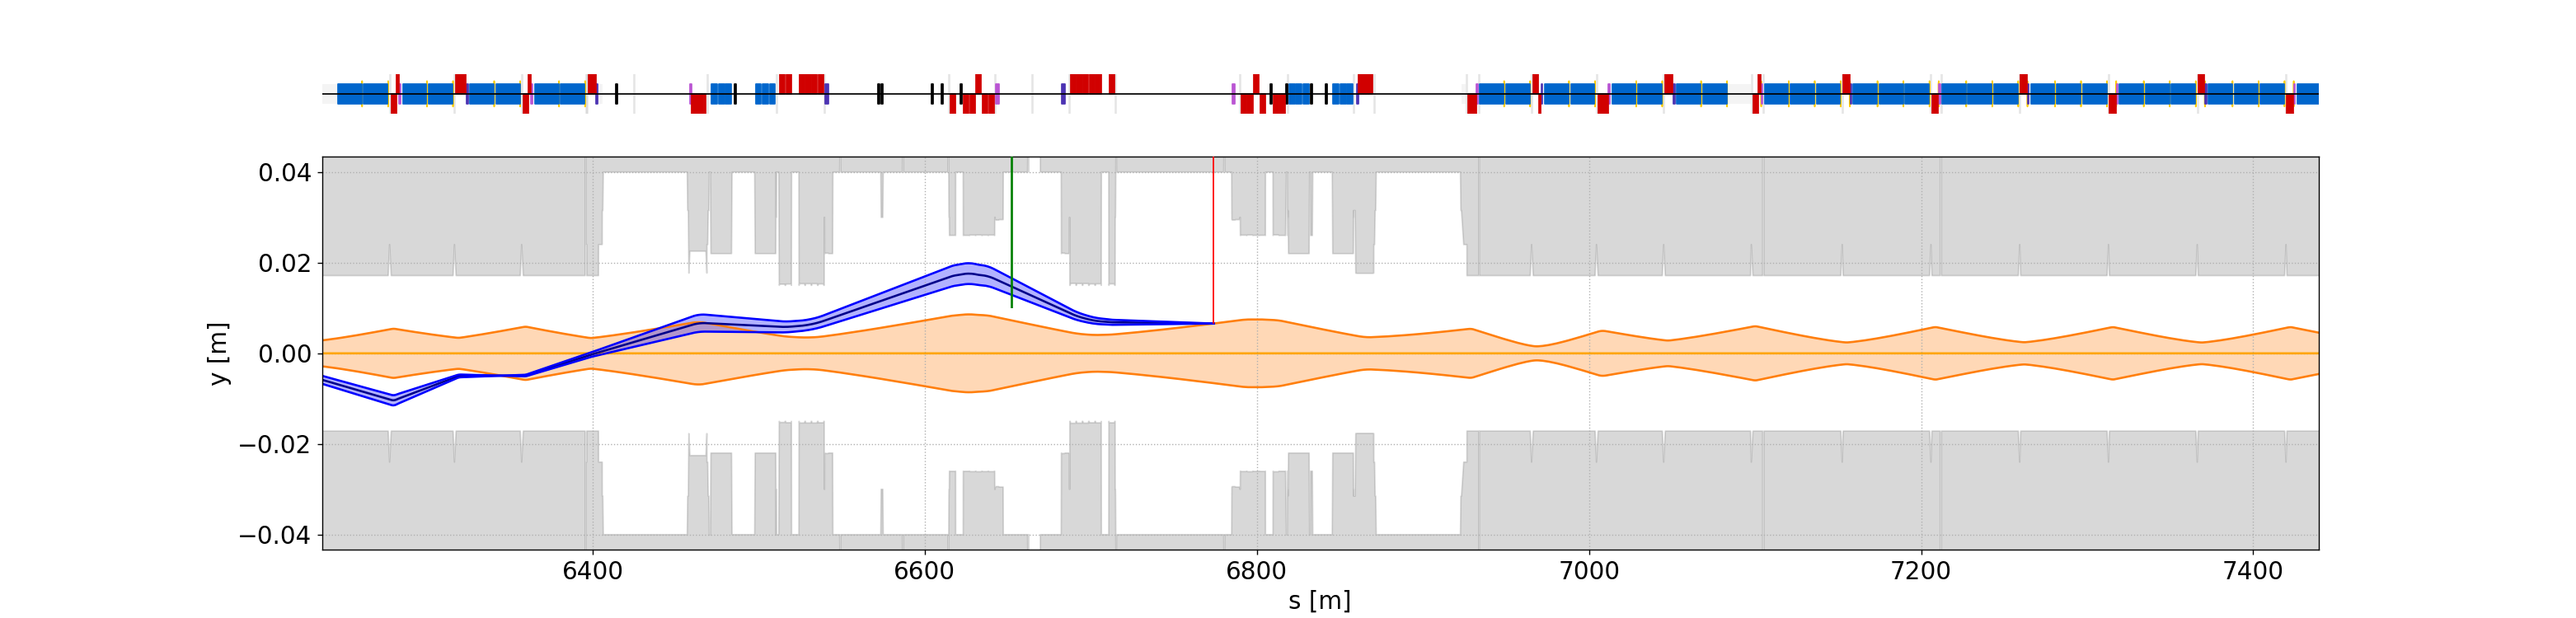

In [33]:
# ---------------- PLOT ----------------
%matplotlib notebook
start, stop = 0, end_s#19000, 21000 #4000, 6000 # 6540,6777  #6540,6777 #6773.8,6774 #6640,6777 #0, end_s #6740,6777
n_env = 5
plot_cry_envelope = True if ignore_crystals else False
figsize = (25,6)
plot_skew = False

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True, figsize=figsize)
pymadx.Plot._SetMachineAxesStyle(ax[0])
pymadx.Plot.DrawMachineLattice(ax[0], layout_data_object)
ax[0].set_xlim(start,stop)
#ir3_plot[0].set_title(label='Energy = 1 TeV', y=1.05, fontsize=18)


df_ref = change_coordinates_to_b1(tw.to_pandas())
ax[1].plot(df_ref["s"],df_ref["y"],color="orange")
ax[1].plot(df_ref["s"], n_env*np.sqrt(emittance*df_ref['bety']) + df_ref['y'], color='C1')
ax[1].plot(df_ref["s"],-n_env*np.sqrt(emittance*df_ref['bety'])+ df_ref['y'], color='C1')
ax[1].fill_between(df_ref["s"], n_env*np.sqrt(emittance*df_ref['bety']) + df_ref['y'], -n_env*np.sqrt(emittance*df_ref['bety'])+ df_ref['y'], color='C1', alpha=0.3)

ax[1].plot(df_chann_L["s"],df_chann_L["y"], color='darkblue')
ax[1].plot(df_chann_R["s"],df_chann_R["y"], color='darkblue')

if plot_cry_envelope:
    ax[1].plot(df_chann_upper_L["s"],df_chann_upper_L["y"], color='blue')
    ax[1].plot(df_chann_upper_R["s"],df_chann_upper_R["y"], color='blue')
    ax[1].plot(df_chann_lower_L["s"],df_chann_lower_L["y"], color='blue')
    ax[1].plot(df_chann_lower_R["s"],df_chann_lower_R["y"], color='blue')
    fill_between(ax[1], df_chann_upper_R, df_chann_lower_R)
    fill_between(ax[1], df_chann_upper_L, df_chann_lower_L)

ax[1].set_xlabel('s [m]',  fontsize=17)
ax[1].set_xlim(start, stop)
ax[1].set_ylim(-0.045, 0.045)
ax[1].set_ylabel('y [m]',  fontsize=17)
ax[1].grid(linestyle=':')
ax[1].tick_params(axis='both', which='major', labelsize=17)
plot_apertures(df_apertures[['xmin', 'xmax', 'ymin', 'ymax']].apply(lambda x: convert_mm_to_m(x)), ax[1], "v")
   
get_jaw(ax[1], PIXEL_name+ '_1', 0.06, tw, end_s, hgap_L = 0.010, color='green')
get_jaw(ax[1],TFT_name, 0.06,  tw, end_s, hgap_L = 0.010, color='green')
#get_jaw(ax[1],TCCP_name, TCCP_length, tw, end_s, hgap_L = float(df_chann[df_chann['name'] == TCCP_name ]['y']), color = 'r')
get_jaw(ax[1],TCCS_name, TCCS_length, tw, end_s, hgap_L= CRY_tw(TCCS_gap, emittance, TCCS_name, tw)[0], color = 'r')
for n in df_colls.name:
    coll = df_colls[df_colls['name'] == n]
    #if coll['angle'].values[0] == 90:
    get_jaw(ax[1],n, coll.length.values[0], tw, end_s, angle = coll.angle.values[0],  hgap_L = coll.jaw_L.values[0], hgap_R = coll.jaw_R.values[0], plot_skew = plot_skew)



In [11]:
line.element_names[cry_part_chann.at_element[0]]

'tcsg.a4r7.b2'

In [41]:
CRY_tw(5, emittance, TCCP_name, tw )[0] 

0.007196882086403974

In [42]:
df_chann_L[df_chann_L.name == TCCP_name].y.iloc[0]

0.014567627296769721

In [46]:
df_chann_L[df_chann_L.name == TCCP_name].y.iloc[0] - CRY_tw(5, emittance, TCCP_name, tw )[0]  

0.007370745210365747

In [47]:
df_chann_lower_L[df_chann_lower_L.name == TCCP_name].y.iloc[0] - CRY_tw(5, emittance, TCCP_name, tw )[0]  

0.005556864783299625

In [51]:
df_chann_upper_L[df_chann_upper_L.name == TCCP_name].y.iloc[0]  - CRY_tw(5, emittance, TCCP_name, tw )[0]  

0.009184625637431875

In [15]:
def calc_nsigma(df_twiss, df_chann, emittance_phy, obj_name, add_offset = 0):
    
    s_centre = float(df_twiss[df_twiss["name"] == obj_name]['s'].iloc[0])
    beta_y = float(df_ref[df_ref["name"] == TCCP_name]['bety'].iloc[0])

    #s_centre = float(df_twiss[df_twiss["name"] == obj_name]['s'])
    hgap =  df_chann[df_chann['s'] == s_centre]['y'].iloc[0]  - df_twiss[df_twiss['s'] == s_centre]['y'].iloc[0] - add_offset
    #beta_y = float(df_twiss[df_twiss["name"] == obj_name]['bety'])
    sigma =  np.sqrt(emittance_phy*beta_y)

    #five_sig_gap  = df_twiss[df_twiss['s'] == s_centre]['n_sigma_y'].iloc[0] - df_twiss[df_twiss['s'] == s_centre]['y'].iloc[0]
    #print('check: ', five_sig_gap/sigma)
    
    return hgap/sigma, hgap 

In [16]:
upper_sig, upper_m = calc_nsigma(df_ref, df_chann_upper_L, emittance, TCCP_name)
central_sig, central_m =  calc_nsigma(df_ref, df_chann_L, emittance, TCCP_name)
lower_sig, lower_m =  calc_nsigma(df_ref, df_chann_lower_L, emittance, TCCP_name)

print(f'\nUpper: {upper_sig:.2f} sigma, {upper_m*1e3:.2f} mm')
print(f'Central: {central_sig:.2f} sigma, {central_m*1e3:.2f} mm')
print(f'Lower: {lower_sig:.2f} sigma, {lower_m*1e3:.2f} mm')
print(f'\nDimesion of the 5 sigma channelled spot (upper-lower): {(upper_m-lower_m)*1e3:.2f} mm   \tCrystal height: 2 mm')
print(f'Center the spot in the crystal: [{central_m*1e3-1:.2f},{central_m*1e3+1:.2f}] mm')
beta_y = float(df_ref[df_ref["name"] == TCCP_name]['bety'].iloc[0])
sigma =  np.sqrt(emittance*beta_y)
print(f'Jaw sigma in order to center: {(central_m-0.001)/sigma:.1f}')


Upper: 11.38 sigma, 16.38 mm
Central: 10.12 sigma, 14.57 mm
Lower: 8.86 sigma, 12.75 mm

Dimesion of the 5 sigma channelled spot (upper-lower): 3.63 mm   	Crystal height: 2 mm
Center the spot in the crystal: [13.57,15.57] mm
Jaw sigma in order to center: 9.4


In [50]:
27 -37

-10

In [17]:
gap = central_sig # 5
TCCP_bend = 7e-3
delta_s = abs(tw['s', TCCP_name] - 0.035 - tw['s', TFT_name])
delta_s = abs(tw['s', TCCP_name] - tw['s', TFT_name])
#delta_s = abs(tw['s', TCCP_name] - 0.035 - tw['s', PIXEL_name+"_1"])
#delta_s = abs(tw['s', TCCP_name] - tw['s', PIXEL_name+"_1"])


CRY_tw(gap, emittance, TCCP_name, tw )[0] +  delta_s *np.tan(TCCP_bend + CRY_tw(gap, emittance, TCCP_name, tw )[1])

0.022728258411252568

In [ ]:
2480 

In [30]:
ang_env = CRY_tw(5, emittance, TCCP_name, tw )[1]*1e6
ang_env

77.59502290031962

In [31]:
ang_dc = df_chann_L[df_chann_L.name == TCCP_name].py.iloc[0]*1e6
ang_dc

166.94706687422828

In [32]:
ang_env - ang_dc

-89.35204397390866

In [18]:
sig = 1.4389e-3
th_beam= 75.95e-6
delta_s = 585.3e-3

gap*sig +  delta_s *np.tan(TCCP_bend + th_beam)

0.018703728082724008

In [19]:
3.14e-3 + CRY_tw(5, emittance, TCCP_name, tw )[0]

0.010336882086403975